---
# 삽질의 흔적

## Multi-Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=42)

lr_clf = LogisticRegression(multi_class='multinomial')
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test 데이터에 대한 정확도: {acc: .4f}")

- Kernel이 죽어버림
- 따라서, 병렬연산과 트리기반의 알고리즘을 사용해야 한다..

## Tensorflow 딥러닝

In [12]:
# 우선 Train : Test 7:3으로 나누기
from sklearn.model_selection import train_test_split

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(feature, target,
                                                   test_size=0.3,
                                                   random_state=42)
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)

Train shape:  (673680, 19)
Test shape:  (288721, 19)


In [13]:
def next_batch(num, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [14]:
import tensorflow as tf

X_train = X_train.values
y_train = y_train.values

y_train_ohe = tf.one_hot(y_train, 10)

num_classes = 10

X = tf.placeholder(tf.float32, shape=[None, 19])
y = tf.placeholder(tf.float32, shape=[None, num_classes])

# layer1 - RELU
W1 = tf.Variable(tf.random_normal([19, 256]), name='weight1')
b1 = tf.Variable(tf.random_normal([256]), name='bias1')
layer1 = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
# layer2 - RELU
W2 = tf.Variable(tf.random_normal([256, 1024]), name='weight2')
b2 = tf.Variable(tf.random_normal([1024]), name='bias2')
layer2 = tf.nn.relu(tf.matmul(layer1, W2) + b2)
# layer3 - RELU
W3 = tf.Variable(tf.random_normal([1024, 512]), name='weight3')
b3 = tf.Variable(tf.random_normal([512]), name='bias3')
layer3 = tf.nn.sigmoid(tf.matmul(layer2, W3) + b3)
# layer4 - Softmax로 최종 분류
W4 = tf.Variable(tf.random_normal([512, num_classes]), name='weight4')
b4 = tf.Variable(tf.random_normal([num_classes]), name='bias4')
hypothesis = tf.nn.softmax(tf.matmul(layer3, W4) + b4)

# cost function - multi_class cross entropy
cost = -tf.reduce_mean(tf.reduce_mean(y * tf.log(hypothesis), axis=1))
# SGD
train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

correct_pred = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

num_epoch = 10
batch_size = 200
num_iter = int(X_train.shape[0] / batch_size)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epoch):
        # epoch 한 번 수행한 후 평균 cost 계산하기 위해 정의
        avg_cost = 0
        avg_acc = 0
        # iteration 
        for i in range(num_iter):
            batch = next_batch(batch_size, X_train, y_train_ohe.eval())
            
            _, cost_val, acc_val = sess.run([train, cost, accuracy], feed_dict={X: batch[0],
                                                            y: batch[1]})
            # Epoch 한번 수행할 동안 평균 cost값 계속 계산
            avg_cost += cost_val / num_iter
            avg_acc  += acc_val / num_iter
        print(f"## Epoch:{epoch+1}번 후, 평균 Cost:{avg_cost:.4f}, 평균 Accuracy:{avg_acc:.4f}")
        print()

## Epoch:1번 후, 평균 Cost:0.2246, 평균 Accuracy:0.1042

## Epoch:2번 후, 평균 Cost:0.2176, 평균 Accuracy:0.1022

## Epoch:3번 후, 평균 Cost:0.2170, 평균 Accuracy:0.0998

## Epoch:4번 후, 평균 Cost:0.2168, 평균 Accuracy:0.1007

## Epoch:5번 후, 평균 Cost:0.2173, 평균 Accuracy:0.1004

## Epoch:6번 후, 평균 Cost:0.2170, 평균 Accuracy:0.0987

## Epoch:7번 후, 평균 Cost:0.2173, 평균 Accuracy:0.0993

## Epoch:8번 후, 평균 Cost:0.2169, 평균 Accuracy:0.0993

## Epoch:9번 후, 평균 Cost:0.2171, 평균 Accuracy:0.1003

## Epoch:10번 후, 평균 Cost:0.2168, 평균 Accuracy:0.0996



- Tensorflow 딥러닝 성능이 매우 낮다. 이럴바엔 차라리 트리, GPU기반 머신러닝모델로 해결!

## Hybrid Voting

- Logistic Regression
- Random Forest
- Light GBM 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

lr_clf = LogisticRegression(multi_class='multinomial')
rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy')
lgbm_clf = LGBMClassifier(n_estimators=400, objective='multiclass',
                         learning_rate=42, random_state=42)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf),
                                     ('RF', rf_clf),
                                     ('LGBM', lgbm_clf)],
                         voting='hard')

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                   target,
                                                   test_size=0.2,
                                                   random_state=43)

vo_clf.fit(X_train, y_train)
y_pred = vo_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"정확도: {accuracy :.4f}")

- Kernel 죽어버림..

---

# 모델링
- 레이블 인코딩한 데이터
    * 오버샘플링 하지 않은 데이터 - 학습시 Cost-sensitive learning 사용해 클래스 불균형 해소 예정
    * SMOTE NC 오버샘플링한 데이터
<br><br>
- 원-핫 인코딩한 데이터-> ``메모리 과부하 걸려서 Kernel이 죽어버림..``
    * 오버샘플링 하지 않은 데이터 - 학습시 Cost-sensitive learning 사용해 클래스 불균형 해소 예정
    * SMOTE NC 오버샘플링한 데이터 
    
<br>

- 모델링 삽질 결과, ``원-핫 인코딩 데이터``는 컴퓨팅 연산으로 Kernel이 죽어버림
- 뿐만 아니라 트리기반 알고리즘에 ``원-핫 인코딩 데이터``는 부적절
- 따라서, 트리기반 알고리즘을 사용하기 위해 **``레이블인코딩``** 데이터 사용
- 또한 클래스 불균형이 존재하는 원본 데이터 -> 40%낮은 성능을 보임
    * cost-sensitive learning 시도해보기
- 하지만 SMOTE 오버샘플링을 이용한 데이터 -> 79%까지 성능 향상

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/healthcare/encoding_df')

In [2]:
# index_col=[0] : index 칼럼을 0번째 칼럼으로 설정해서 Unnamed 제거시키기

label_df = pd.read_csv('label_df.csv', index_col=[0])
label_smote_df = pd.read_csv('label_smote_df.csv', index_col=[0])
#ohe_df = pd.read_csv('ohe_df.csv', index_col=[0])
#ohe_smote_df = pd.read_csv('ohe_smote_df.csv')

- 두 개의 dataframe으로 개별적으로 저장한 이유: SMOTE하는 시간이 약 10분걸리므로 시간 단축하기 위해 개별 csv파일 2개로 저장 후 로드함

## 데이터 분할

- Train : Validation : Test = 6 : 2 : 2로 분할
    * 해당 비율로 성능 좋을 시, Test 비율을 늘려 실제 상용화에 근접한 상황까지 고려

In [4]:
from sklearn.model_selection import train_test_split

feature = label_df.iloc[:,:-1]
target = label_df.iloc[:, -1]

X_train, X_val_test, y_train, y_val_test = train_test_split(feature, target, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=43)

print(f"Train 데이터 개수/비율:{X_train.shape[0]},{int((X_train.shape[0]/feature.shape[0])*100)}%")
print(f"Validation 데이터 개수/비율:{X_val.shape[0]},{int((X_val.shape[0]/feature.shape[0])*100)}%")
print(f"Test 데이터 개수/비율:{X_test.shape[0]},{int((X_test.shape[0]/feature.shape[0])*100)}%")

Train 데이터 개수/비율:191062,59%
Validation 데이터 개수/비율:63688,20%
Test 데이터 개수/비율:63688,20%


In [3]:
# class_weight인자를 넣을 수 있는 Random Forest로 SMOTE vs Cost-sensitive learning 비교


,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission,Severity of Illness,Age,Hospital_type_a_binary,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit,Visitors_Robust,Visitors_Q3_ohe,Admission_Deposit_Robust,Admission_Deposit_Q3_ohe,Admission_Deposit_Discretization,Y_Stay
0,2,2,2,3,2,5,0,0,5,0.0,3,2,4911.0,-0.5,0.0,0.139002,0.0,5.0,0
1,2,4,2,3,3,5,1,0,5,0.0,2,2,5954.0,-0.5,0.0,0.991823,1.0,8.0,4
2,4,0,0,1,3,4,1,0,5,0.0,2,2,4745.0,-0.5,0.0,0.003271,0.0,5.0,3
3,1,1,1,3,2,3,1,0,5,0.0,2,2,7272.0,-0.5,0.0,2.069501,1.0,9.0,4
4,1,1,1,3,3,3,1,0,5,0.0,2,2,5558.0,-0.5,0.0,0.668029,1.0,7.0,4


## Random Forest 
- 레이블 인코딩은 트리 기반에 강하다..!

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy',
                               min_samples_split=10)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"테스트 데이터에 대한 정확도: {acc: .4f}")

테스트 데이터에 대한 정확도:  0.7973


## Light GBM

- 성능 향상위한 Feature engineering
- 정답 사후 분석 시도
    * accuracy, recall, precision, f1 중 중요 지표 무엇인지 고민
    * 모델이 주로 어떤 클래스에서 오답을 내는지 관찰
- 도메인 지식에 기반해 종속변수 level 개수 줄여보기

In [3]:
import re
label_df = label_df.rename(columns= lambda x : re.sub('[^A-Za-z0-9]+', '', x))

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_eval(y, y_, labels):
    acc = accuracy_score(y, y_)
    pre = precision_score(y, y_, labels=labels, average=None)
    rec = recall_score(y, y_, labels=labels, average=None)
    f1 = f1_score(y, y_, labels=labels, average=None)
    return acc, pre, rec, f1

# 테스트 데이터에 대한 정확도:  0.7949


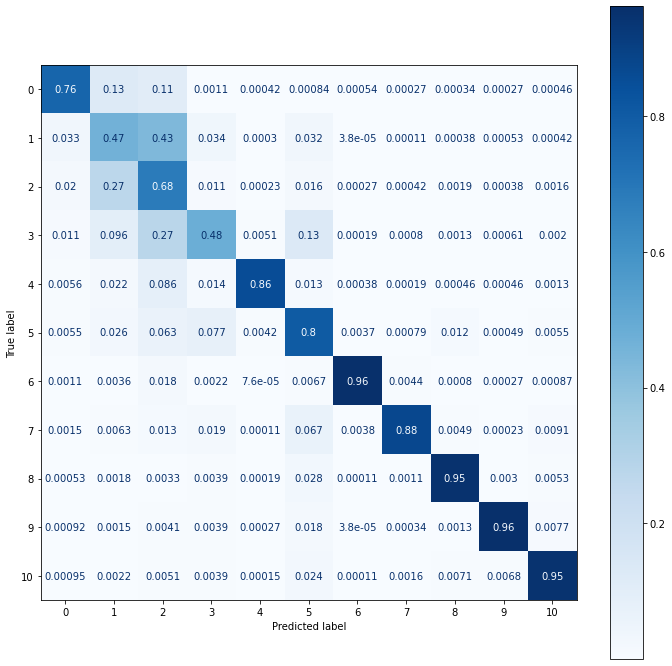

In [5]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                   target,
                                                   test_size=0.3,
                                                   random_state=12)
lgbm = LGBMClassifier(objective='multiclass',
                      n_estimators=400, learning_rate=0.1,
                     random_state=42)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
labels = [a for a in range(0,11)]

acc, pre, rec, f1 = get_eval(y_test, y_pred, labels)


print(f"# 테스트 데이터에 대한 정확도: {acc: .4f}")
scores_df = pd.DataFrame(data={'Precision':pre,
                               'Recall':rec,
                               'F1-score':f1}, index=labels)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(lgbm, X_test, y_test, normalize='true',
                     cmap=plt.cm.Blues, ax=ax)
plt.show()

In [30]:
scores_df

,Precision,Recall,F1-score
0,0.374916,0.159373,0.223667
1,0.401120,0.404973,0.403037
2,0.401128,0.679054,0.504336
3,0.410260,0.185750,0.255720
4,0.064516,0.001122,0.002206
5,0.390301,0.525453,0.447904
6,0.052632,0.001252,0.002445
7,0.347150,0.022141,0.041628
8,0.320887,0.188098,0.237171
9,0.342105,0.031288,0.057332
